In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

from tensorflow.keras import Model
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
def preprocessData(seq):
    """This function serves to preprocess the genomics_ood sequences and should be used as 
    a mapping funtion for tf.data.Dataset objects. The DNA-base sequence will be translated
    into a tf.tensor with one_hot encoding.

    Args:
        seq: tf.tensor(dtype=tf.string)
            The base sequence that should be encoded.

    Returns:
        The encoded sequence.

    """
    
    translation = {'A': '0', 'T': '1', 'G': '2', 'C': '3'}
    
    for base, number in translation.items():
        seq = tf.strings.regex_replace(seq, base, number)
    seq = tf.strings.bytes_split(seq)
    seq = tf.strings.to_number(seq, out_type=tf.dtypes.int32)
    seq = tf.one_hot(seq, 4, dtype=tf.uint8)
    seq = tf.reshape(seq, (-1,))

    return seq
   
def preprocessTarget(target):
    """This function serves to preprocess the genomics_ood targets and should be used as 
    a mapping funtion for tf.data.Dataset objects. The target will be translated
    into a tf.tensor with one_hot encoding.

    Args:
        target: tf.tensor(dtype=tf.int32)
               The target that should be encoded.

    Returns:
        The encoded target.

    """
    
    target = tf.cast(target, tf.uint8)
    target = tf.cast(tf.one_hot(target, 10), tf.uint8)
    target = tf.reshape(target, (-1,))
    
    return target

class Model(Model): 
    def __init__(self):
        super(Model, self).__init__()
        # Define the hidden layer
        self.hidden_layer_1 = layers.Dense(units=256, 
                                           activation=tf.keras.activations.sigmoid)
        
        self.hidden_layer_2 = layers.Dense(units=256, 
                                           activation=tf.keras.activations.sigmoid)
        
        self.output_layer = layers.Dense(units=10, 
                                         activation=tf.keras.activations.softmax, 
                                         use_bias=False)
                                               
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x
    
def train_step(model, input, target, loss_function, optimizer, acc_function):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        accuracy = acc_function(prediction, target)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, accuracy

def test(model, data, loss_function, acc_function):
    # calculates loss and accuracy of a given dataset (train, test, validation)

    test_loss = []
    test_accuracies = []

    for (input, target) in data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_acc = acc_function(prediction, target)
        test_loss.append(sample_test_loss.numpy())
        test_accuracies.append(sample_test_acc.numpy())

    test_loss = np.mean(test_loss)
    test_acc = np.mean(test_accuracies)

    return test_loss, test_acc

In [3]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95
train_batch_size = 8
test_batch_size = 8
buffer = 512
prefetch_factor = tf.data.experimental.AUTOTUNE

#------------------------------------------------------------------------------------------------
# loading the dataset and preprocess the data
print('[INFO] - Loading and processing the Dataset')

train_samples = 100000
test_samples = 1000

train_ds, test_ds = tfds.load('genomics_ood', 
                              split = [f'train[:{train_samples}]',f'test[:{test_samples}]'], 
                              as_supervised = True)

# train_ds = train_ds.batch(train_batch_size)
# test_ds = test_ds.batch(test_batch_size)

train_ds = train_ds.map(lambda data, target: (preprocessData(data), preprocessTarget(target)),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(lambda data, target: (preprocessData(data), preprocessTarget(target)), 
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_ds = train_ds.batch(train_batch_size).shuffle(buffer_size=buffer).prefetch(prefetch_factor)
test_ds = test_ds.batch(test_batch_size).shuffle(buffer_size=buffer).prefetch(prefetch_factor)

print('[INFO] - Finished loading and processing the Dataset')
#------------------------------------------------------------------------------------------------
# initialize the model and specify parameters
tf.keras.backend.clear_session()

# Initialize the model.
model = Model()
cce = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize loss and accuracy lists for visualization purposes.
train_losses = []
train_accuracies=[]

test_losses = []
test_accuracies = []

print('[INFO] - Started testing')

# Testing and build of the model
test_loss, test_accuracy = test(model, test_ds, cce, acc)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print('[INFO] - Finished testing')

#------------------------------------------------------------------------------------------------
# Analyzing the model performance before learning
train_loss,train_accuracy = test(model, train_ds, cce, acc)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# training of the network
print('[INFO] - Started Model training')

for epoch in range(num_epochs):
    print(f'Epoch: {epoch:>2} - train_loss: {train_losses[-1]:>4.2f} - train_accuracy: {train_accuracies[-1]:>4.2f} - test_loss: {test_losses[-1]:>4.2f} - test_accuracy: {test_accuracies[-1]:>4.2f}')

    train_ds = train_ds.shuffle(buffer_size=buffer)
    test_ds = test_ds.shuffle(buffer_size=buffer)
    
    running_average_loss = 0
    
    for (input, target) in train_ds:
        train_loss, train_accuracy = train_step(model, input, target, cce, optimizer, acc)
        
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
        
    train_losses.append(running_average_loss)
    train_accuracies.append(train_accuracy)

    # Evaluating performence of the network
    test_loss, test_acc = test(model, test_ds, cce, acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

print(f'[INFO] - Final loss: {test_losses[-1]}')
print(f'[INFO] - Final accuracy: {test_accuracies[-1]}')

[INFO] - Loading and processing the Dataset
[INFO] - Finished loading and processing the Dataset
[INFO] - Started testing
[INFO] - Finished testing
[INFO] - Started Model training
Epoch:  0 - train_loss: 2.42 - train_accuracy: 0.10 - test_loss: 2.38 - test_accuracy: 0.10
Epoch:  1 - train_loss: 1.52 - train_accuracy: 0.22 - test_loss: 1.47 - test_accuracy: 0.22
Epoch:  2 - train_loss: 1.45 - train_accuracy: 0.27 - test_loss: 1.47 - test_accuracy: 0.27
Epoch:  3 - train_loss: 1.46 - train_accuracy: 0.29 - test_loss: 1.45 - test_accuracy: 0.29
Epoch:  4 - train_loss: 1.41 - train_accuracy: 0.31 - test_loss: 1.49 - test_accuracy: 0.31
Epoch:  5 - train_loss: 1.44 - train_accuracy: 0.32 - test_loss: 1.45 - test_accuracy: 0.32
Epoch:  6 - train_loss: 1.39 - train_accuracy: 0.33 - test_loss: 1.45 - test_accuracy: 0.33
Epoch:  7 - train_loss: 1.35 - train_accuracy: 0.34 - test_loss: 1.40 - test_accuracy: 0.34
Epoch:  8 - train_loss: 1.46 - train_accuracy: 0.35 - test_loss: 1.39 - test_accurac

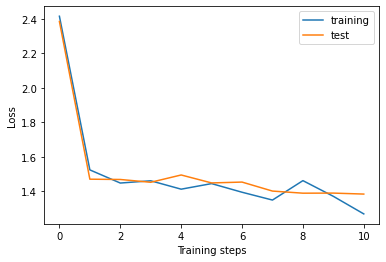

In [4]:
# Visualize loss for training and test data. 

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

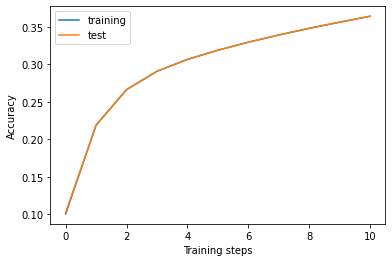

In [5]:
# Visualize accuracy for training and test data. 

plt.figure()
line1, = plt.plot(train_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1,line2),("training","test"))
plt.show()